# Assignment VI: Topic Modeling

## Question 1

Perform an analysis of Topic Modeling on the corpus, `nltk.corpus.movive_reviews`, and provide the topic distributions of the movie reviews. Please report your topic distributions of positive and negative reviews respectively. (But please note that the topic modeling analysis should take the entire corpus as the input.)

Some heuristics for data preprocessing/vectorization:

- Include in the bag-of-words representation only words whose lengths are >= 3
- Include in the bag-of-words representation only words that are nouns (`NN` or `NNS`) or verbs (`VB.`)
- Lemmatize all words in the bag-of-words representation using WordNet
- Remove words on the stopwords list in `nltk.corpus.stopwords.words('english')`
- Play with the `min_df` and `max_df` to find a better structure of CountVectorizer for the topic modeling


:::{warning}

As this is an unsupervised learning, it is ok if you get different results. Please base your interpretations of the topics by examining closely their respective associated words in your LDA model.

:::

##**Load packages**

In [1]:
import nltk, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [2]:
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##**Text preprocessing**

In [3]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    filtered = [
        lemmatizer.lemmatize(word.lower(), pos='v' if pos == 'VB' else 'n')
        for word, pos in tagged
        if len(word) >= 3 and pos in ('NN', 'NNS', 'VB') and word.lower() not in stop_words
    ]
    return ' '.join(filtered)

# Load movie reviews and preprocess each review separately
preprocessed_reviews = [preprocess(movie_reviews.raw(fileid)) for fileid in movie_reviews.fileids()]

# See the number of preprocessed reviews and the first preprocessed review
print(f"Total reviews preprocessed: {len(preprocessed_reviews)}")
print(f"Snippet of the first preprocessed review: {preprocessed_reviews[0][:100]}")

Total reviews preprocessed: 2000
Snippet of the first preprocessed review: plot teen couple church party drink drive accident guy girlfriend see life nightmare deal watch movi


##**Text vectorization**

In [4]:
# Vectorize the words in movie reviews
reviews_cv = CountVectorizer(min_df=5,
                             max_df=300,
                             token_pattern=r'\b[a-zA-Z]{3,}\b')
reviews_matrix = reviews_cv.fit_transform(preprocessed_reviews)
reviews_matrix

<2000x6975 sparse matrix of type '<class 'numpy.int64'>'
	with 180189 stored elements in Compressed Sparse Row format>

In [5]:
# Doc-by-word matrix
reviews_vocab = reviews_cv.get_feature_names_out()

# View BOA in df
pd.DataFrame(reviews_matrix.toarray(), columns = reviews_vocab)

,aaron,abandon,abby,abduction,ability,abode,abortion,abraham,absence,absent,...,zest,zeta,zinger,zoe,zombie,zone,zoo,zoom,zucker,zwick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##**Topic modeling with LDA**

In [6]:
%%time

lda_model = LatentDirichletAllocation(n_components=4,  # Number of topics to generate by the LDA model.
                                      max_iter=500,    # Maximum number of iterations for the optimization algorithm.
                                      random_state=0)  # Random Seed
d_t_matrix = lda_model.fit_transform(reviews_matrix)  # Fit the LDA model

CPU times: user 4min 45s, sys: 458 ms, total: 4min 46s
Wall time: 4min 55s


In [7]:
# log-likelihood
print(lda_model.score(reviews_matrix))

# perplexity
print(lda_model.perplexity(reviews_matrix))

-1911475.4614087208
3579.205858955836


In [8]:
# Check doc-by-topic matrix
print(d_t_matrix.shape)

# Check topic-by-word- matrix
print(lda_model.components_.shape)

(2000, 4)
(4, 6975)


In [9]:
# Doc-by-topic matrix
d_t_df = pd.DataFrame(d_t_matrix, columns=['T1', 'T2', 'T3', 'T4'])
d_t_df

,T1,T2,T3,T4
0,0.151012,0.272985,0.258909,0.317094
1,0.005675,0.982812,0.005805,0.005708
2,0.003520,0.003522,0.779335,0.213622
3,0.002855,0.991603,0.002764,0.002778
4,0.445221,0.001946,0.001976,0.550857
...,...,...,...,...
1995,0.582058,0.003043,0.411863,0.003035
1996,0.004661,0.004585,0.986087,0.004667
1997,0.001037,0.605523,0.392407,0.001033
1998,0.060140,0.828077,0.109439,0.002344


In [10]:
# Topic-by-word matrix
t_w_matrix = lda_model.components_
pd.DataFrame(t_w_matrix, columns = reviews_vocab) # Identify words with high weightings
pd.DataFrame(np.transpose(t_w_matrix), index = reviews_vocab) # Transpose

,0,1,2,3
aaron,0.260711,3.819304,8.654040,0.265945
abandon,7.477377,8.888264,11.562433,2.071926
abby,9.764158,0.255520,0.258848,3.721473
abduction,0.258988,2.261896,5.226870,0.252246
ability,40.430086,55.230245,50.954971,41.384698
...,...,...,...,...
zone,9.809330,9.984119,8.391065,2.815486
zoo,2.092093,0.286362,0.251515,4.370030
zoom,13.381739,1.740512,3.585515,0.292234
zucker,5.278536,0.262591,0.251687,9.207186


##**Interpretation**

In [11]:
# Customized function

def get_topics_meanings(tw_m,   # topic-by-word matrix
                        vocab,
                        display_weights=False,
                        topn=5, # ranking
                        weight_cutoff=0.6):
    """
    This function sorts the words importance under each topic and
    allows selecting words based on ranks or a cutoff on weights.

    Parameters:
    - tw_m : array-like
        Topic by Word matrix containing the weights of each word in each topic.
    - vocab : list
        List of words in the vocabulary.
    - display_weights : bool, optional (default=False)
        Flag to indicate whether to display words with their weights.
    - topn : int, optional (default=5)
        Number of top words to display for each topic if display_weights is False.
    - weight_cutoff : float, optional (default=0.6)
        Weight cutoff threshold for displaying words if display_weights is True.
    """
    for i, topic_weights in enumerate(tw_m):
        topic = [(token, np.round(weight, 2)) for token, weight in zip(vocab, topic_weights)]
        topic = sorted(topic, key=lambda x: -x[1])
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff]
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

In [51]:
# get_topics_meanings(t_w_matrix,
#                     reviews_vocab,
#                     display_weights=True,
#                     weight_cutoff=2)

In [13]:
get_topics_meanings(t_w_matrix,
                    reviews_vocab,
                    display_weights=False,
                    topn=20)

Topic #0 :
school sex mother boy humor joke brother laugh house joe parent town dog talent song wedding son room game review
Topic #1 :
war alien ship planet disney earth space computer science battle horror crew city voice mission event fan animation fiction element
Topic #2 :
murder crime vampire cop police thriller book violence shot city daughter prison batman novel viewer style law kill husband car
Topic #3 :
jackie scream horror killer smith summer car fight brother chan joke sequel flick truman godzilla hero villain thriller james agent


##**Visualization**

###**Words associated with topics**

In [49]:
# Function to plot top words of each topic
def plot_top_words(lda_model, feature_names, n_top_words, title, fig_grid, topic_names):
    fig, axes = plt.subplots(fig_grid[0], fig_grid[1], figsize=(12, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5)
        ax.set_title(f'{topic_names[topic_idx]}', fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

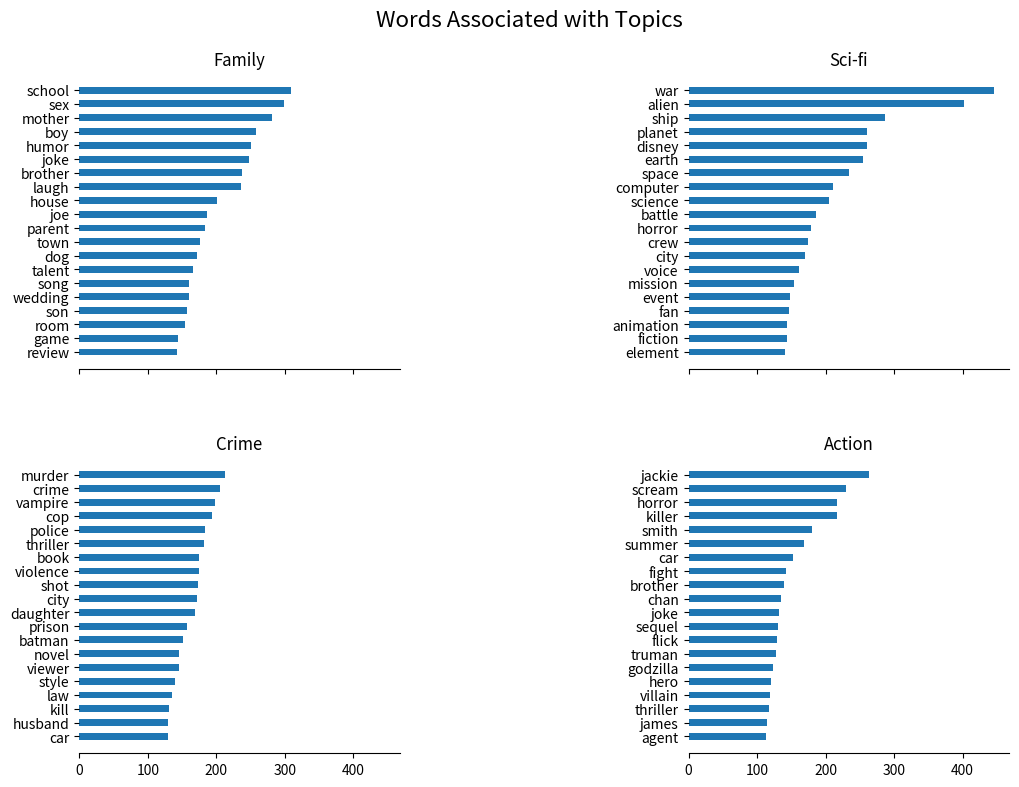

In [50]:
# Define the number of words to show for each topic
n_top_words = 20

# Topic labels
topics = ['Family', 'Sci-fi', 'Crime', 'Action']

# Call the function
plot_top_words(lda_model, reviews_vocab, n_top_words, "Words Associated with Topics", fig_grid=[2, 2], topic_names = topics)

###**Number of words by topic in positive and negative reviews**

In [16]:
# Determine the predominant topic for each review
predominant_topics = np.argmax(d_t_matrix, axis=1)

# Initialize counts
positive_counts = np.zeros(lda_model.n_components)
negative_counts = np.zeros(lda_model.n_components)

# Categorize reviews and tally counts
for i, fileid in enumerate(movie_reviews.fileids()):
    category = movie_reviews.categories(fileid)[0]  # 'pos' or 'neg'
    topic = predominant_topics[i]
    if category == 'pos':
        positive_counts[topic] += 1
    else:
        negative_counts[topic] += 1

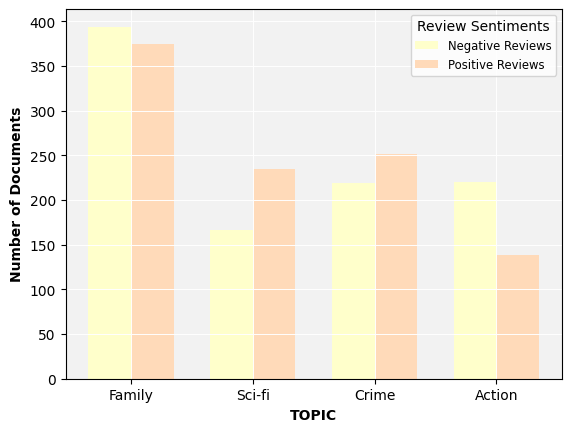

In [17]:
# Setting up the bar width
bar_width = 0.35

# Setting up the positions of the bars on the x-axis
r1 = np.arange(len(positive_counts))
r2 = [x + bar_width for x in r1]

# Creating the bars for negative and positive reviews without edge color
plt.bar(r1, negative_counts, color='#FFFFCB', width=bar_width, label='Negative Reviews')
plt.bar(r2, positive_counts, color='peachpuff', width=bar_width, label='Positive Reviews')

# Add xticks on the middle of the group bars
plt.xlabel('TOPIC', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(positive_counts))], topics)

# Creating the y-axis label
plt.ylabel('Number of Documents', fontweight='bold')

# Setting the background color to light grey and adding white grid lines
plt.gca().set_facecolor('#f2f2f2')
plt.grid(color='white', linestyle='-', linewidth=0.7)

# Create legend with a smaller font size & without frame (contour) and title 'Review Sentiments'
plt.legend(title='Review Sentiments', fontsize='small')
plt.show()

##**Hyper-parameter tuning**

In [18]:
# %%time

# # Prepare hyperparameters dict
# search_params = {'n_components': range(3,8), 'learning_decay': [.5, .7]} # from .5 to 1

# # Initialize LDA
# model = LatentDirichletAllocation(learning_method='batch', ## `online` for large datasets (one at a time)
#                                   max_iter=10,
#                                   random_state=0)

# # Gridsearch
# gridsearch = GridSearchCV(model,
#                           param_grid=search_params,
#                           n_jobs=-1,
#                           verbose=1) # observe the results
# gridsearch.fit(reviews_matrix)

# # Save the best model
# best_lda = gridsearch.best_estimator_

## Question 2

Use the `demo_data/dcard-top100.csv` dataset (the same one used in the previous Assignment) and perform topic modeling on the dataset to explore the main topics of this small corpus.

To increase the interpretability of the topic modeling results, please word-segment the corpus data using `ckip-transformers` and then include word tokens whose POS indicate they are either nouns or verbs. However, please exclude pronouns and numerals. Also, before word segmentation, please preprocess the texts by removing alphabets, digits, and symbols first.

Please report (a) the meanings of the topics and their associated top 20 words in the corpus, and (b) the distribution of the topics in the entire corpus.

##**Load packages**

In [19]:
!pip install -U ckip-transformers

In [20]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ckip_transformers
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Download Chinese font for visualization
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-03-28 13:40:41--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.68.138, 74.125.68.101, 74.125.68.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-03-28 13:40:41--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.175.132, 2404:6800:4003:c1c::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.175.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  55.6MB/s    in 0.4s    

2024-03-28 13:40:47

##**Load the `dcard-top100` corpus**

In [21]:
import os
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Set working directory
os.chdir('/content/drive/MyDrive/ENC2045_demo_data')
print(os.getcwd())

/content/drive/MyDrive/ENC2045_demo_data


In [23]:
# Load the data
dcards = pd.read_csv("dcard-top100.csv")

# View the data
print(dcards.head(5))

print("="*50)

# Check column names
print(dcards.columns)

          ID              title  \
0  235443715   三更 21歲這年我差點被活活燒死   
1  235442609  超狂學經歷！195公分帥家教徵學生   
2  235441998     我的模特界時間管理大師前男友   
3  235441259               豆皮加爆   
4  235442693            這樣女生該追嗎   

                                             content  
0  部分回應在B117 \n謝謝各位的留言，我都有看完\n好的不好的，我都接受謝謝大家🙇‍♀️\...  
1  https://i.imgur.com/REIEzSd.jpg\n\n身高195公分的男大生...  
2  看過這麼多在Dcard、PTT上的感情渣事和創作文\n從沒想過如此荒謬像八點檔的事情居然會發...  
3  剛剛吃小火鍋，跟店員說不要金針菇（怕卡牙縫），於是店員幫我換其他配料..…\n\n沒想到餐一...  
4  已經約好見面，到了當天晚上七點半才回，我是被耍了嗎 \n如下圖\n\n\nhttps://i...  
Index(['ID', 'title', 'content'], dtype='object')


In [24]:
# Extract contents in 'dcard-top100.csv' to list
dcards_content = dcards['content'].tolist()

##**Text preprocessing**

In [25]:
# Remove alphanumeric characters, punks, emojis, etc.
clean_texts = []
for text in dcards_content:
    # Keep only Chinese characters
    new_text = re.sub(r'[^\u4E00-\u9FFF]', ' ', text)
    # Replace one or more whitespace characters with a single space
    new_text = re.sub(r'\s+', ' ', new_text).strip()
    clean_texts.append(new_text)

# Clean_texts contains 100 cleaned documents with single spaces between words
dcards_cleaned_list = clean_texts

# Check the first two cleaned documents
dcards_cleaned_list[:2]

['部分回應在 謝謝各位的留言 我都有看完 好的不好的 我都接受謝謝大家 第三次更新在這邊 這邊也有講到怎麼逃生 很多人好奇我是怎麼踹門的 在這邊跟大家說一下 因為這台車本來就很老舊 加上我文章說的我有停在路邊檢查 之前有在練空手道 所以比較知道怎麼施力 謝謝大家的關心 其他比較有問題的我會在留言一一回覆 後續處理的部分 租車公司的話 他有很多間公司我當時租車的地方在新莊中原路 我是在平台上訂的 租車公司沒有跟平台講 是我家人主動跟平台聯繫 所有的馬 都被下架 另外 前幾天有開事故會議 平台的律師態度是覺得不需要賠很多錢 因為他在談話中談到想用 元跟我和解 但是我燒壞的東西跟經歷了那場浩劫的我 實在是沒辦法接受 難不成一條人命只值 嗎 對這個平台的律師感到非常不解 如果和解談不成的話 可能會上訴 目前車子在等待第三方鑑定 鑑定完後會再談一次 以下正文 號這天 我跟我的朋友們要去台中吃燒烤 因為大家都住在北部 所以想說租一台車一起下去比高鐵便宜 加上大家都會開車 可以輪流開 租車的人是我本人 因為非常臨時租車 所以我上網查到一個平台是提供租車服務 非常方便也很便宜 這是我租車當時的資料 沒想到我當天取車的時候 老闆跟我說他派錯人手了 請我搭計程車到新莊的總站去牽車 這是我當時去全家按的計程車證明聯 而到了現場 老闆態度還不錯 但因為我在台中的燒肉店有預約下午一點 我跟他說我已經有點被耽誤了 我還要去桃園接我朋友才能一起下去 所以老闆二話不說叫我簽名蓋指紋章後 立馬把車開到門口讓我出發 是已經發動引擎的狀態 這邊我知道我不應該沒檢查就開出去 真的很後悔 開出去的時候都還好 但是開了 分鐘後我要上快速道路前 我發現我的車子被限速在 儀表板上面顯示我的車門沒有關好 所以我停在路邊檢查我的車子 我把門關好之後 又繼續開出去 發現車子可以開到 以上以後 我才開上五楊高架 在這中間我發現我的引擎聲很不對勁 可是我已經上高架橋上了沒辦法停下來 直到我踩到 以上的時候 我的車子開始不受控制 聲音超大開始冒白煙 我只能往高乘載道上開 因為後面比較沒車我怕車子爆炸波及到別人 這是當時的狀況 因為車子已經無法發動 門也被鎖死我被關在裡面 我沒辦法跑出去 當下的心情真的很複雜 我只能想辦法把門踹開 我用了全力踹門才衝出去 但是我的包包跟所有東西還全部在副駕上 因為煙越來越大 開始冒小火 我沒

##**Word segmentation & POS tagging**

In [26]:
%%time

# Initialize drivers
ws_driver = CkipWordSegmenter(model = "bert-base", device = 0)
pos_driver = CkipPosTagger(model = "bert-base", device = 0)
# ner_driver = CkipNerChunker(model = "bert-base", device = 0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CPU times: user 764 ms, sys: 697 ms, total: 1.46 s
Wall time: 4.1 s


In [27]:
# Run pipeline
ws = ws_driver(dcards_cleaned_list)
pos = pos_driver(ws)
# ner = ner_driver(dcards_cleaned_list)

Inference: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


In [28]:
## Check the result
# ws[:2]
# pos[:2]

In [29]:
# Define POS tags to include and exclude
include_tags = {'Na', 'Nb', 'Nc', 'Ncd', 'Nd',
                'VA', 'VB', 'VC', 'VCL', 'VD',
                'VF', 'VE', 'VG', 'VH', 'VHC',
                'VI', 'VJ', 'VK', 'VL', 'Nv', 'Ng'}              # POS tags for nouns and verbs
exclude_tags = {'Nep','Neqa', 'Neqb', 'Nes', 'Neu', 'Nf', 'Nh'}  # POS tags for pronouns and numerals

# Filter words based on POS tags
filtered_ws = []
for sentence_ws, sentence_pos in zip(ws, pos):
    filtered_sentence = [word for word, tag in zip(sentence_ws, sentence_pos) if tag in include_tags and tag not in exclude_tags]
    filtered_ws.append(filtered_sentence)

## Check the filtered words
# filtered_ws[:10]

In [30]:
# Join the tokens in each sublist to form a single string per document
corpus = [' '.join(sentence) for sentence in filtered_ws]

# `corpus` is a list of strings, where each string is a document
corpus_df = pd.DataFrame({'Corpus': corpus})
corpus_df

,Corpus
0,回應 謝謝 留言 看完 好 好 接受 謝謝 更新 這邊 這邊 講到 逃生 人 好奇 踹 門 ...
1,身高 公分 男 大生 楊承翰 家教 社團 文徵 學生 文章 網友 推爆 網友 們 看到 學經...
2,看 上 感情 渣事 創作 文 想 如此 荒謬 八點檔 事情 發生 身 上 以為 交往 男友 ...
3,吃 小 火鍋 店員 說 要 金針菇 怕 卡 牙縫 店員 換 配料 餐 上桌 竟是 豆皮 加 ...
4,約好 見面 到 當天 晚上 七點半 回 耍 下圖
...,...
95,感謝 之間 連結 帶領 來到 這裡 主題 愛情 塔羅 感情 關係 感情 關係 人 近期 發展...
96,近期 購入 古董包 新歡 讓 愛不釋手 古董包 緣故 包況 理想 狀況 帶有 小 瑕疵 接受...
97,公車 上 阿伯 下車 前 說 妹妹 愛心 讓 位置 給 人 裝睡 講完 話 瞄 旁邊 女生 ...
98,好 這裡 金魚 占卜 適合 斷聯 曖昧 復合 族群 上 圖 之前 置入 占卜 人 能量 請 ...


##**Text vectorization & Topic modeling**

In [31]:
# Vectorization
vectorizer = CountVectorizer(min_df=0.,
                             max_df=1.)
doc_term_matrix = vectorizer.fit_transform(corpus)

In [32]:
# Topic Modeling with LDA, finding 7 topics
lda = LatentDirichletAllocation(n_components=7,
                                max_iter = 500,
                                random_state=0)
doc_topic_matrix = lda.fit_transform(doc_term_matrix)

# Doc-topic matrix
doc_topic_df = pd.DataFrame(doc_topic_matrix, columns=['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])
doc_topic_df

# # Display the topics and their top words
# feature_names = vectorizer.get_feature_names_out()
# for topic_idx, topic in enumerate(lda2.components_):
#     top_features_ind = topic.argsort()[:-20 - 1:-1]  # Indices of top 10 features for this topic
#     top_features = [feature_names[i] for i in top_features_ind]
#     weights = topic[top_features_ind]

#     print(f"Topic #{topic_idx + 1}:")
#     print(", ".join(top_features))
#     print("\n")

,T1,T2,T3,T4,T5,T6,T7
0,0.000584,0.000584,0.000584,0.000584,0.000584,0.996496,0.000584
1,0.000668,0.000668,0.000668,0.000668,0.000668,0.000668,0.995991
2,0.000299,0.000298,0.000299,0.998207,0.000299,0.000299,0.000299
3,0.010298,0.010209,0.010241,0.010232,0.010208,0.010235,0.938577
4,0.538415,0.020408,0.020464,0.359381,0.020414,0.020443,0.020473
...,...,...,...,...,...,...,...
95,0.991242,0.001459,0.001460,0.001461,0.001460,0.001460,0.001459
96,0.993956,0.001007,0.001007,0.001007,0.001007,0.001008,0.001008
97,0.007953,0.007942,0.007947,0.007952,0.952311,0.007940,0.007955
98,0.000442,0.000441,0.000441,0.997352,0.000441,0.000441,0.000441


In [33]:
# Calculate log-likelihood
print(lda.score(doc_term_matrix))

# Calculate perplexity
print(lda.perplexity(doc_term_matrix))

## 7 topics is the best

-82756.56388474256
3090.7784874713466


In [34]:
# Check all lexical features
vocab = vectorizer.get_feature_names_out()

# View BOA in df
doc_term_matrix = doc_term_matrix.toarray()
pd.DataFrame(doc_term_matrix, columns=vocab)

,一下,一文不值,一會,一會兒,一月,一様,一樣,一生,一致性,一陣子,...,黴菌,鼓勵,鼓起,鼠尾草,鼻子,鼻水,鼻翼,鼻頭,龍年,龍涎香
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,4,0,0,0,1,0,2,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Topic-word matrix
topic_word_matrix = lda.components_

# Check weighted words in dataframe
pd.DataFrame(topic_word_matrix, columns=vocab) # identify words with high weightings
pd.DataFrame(np.transpose(topic_word_matrix), index=vocab)

,0,1,2,3,4,5,6
一下,13.682692,3.142911,5.602875,10.142824,7.143062,2.142778,0.142857
一文不值,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,1.142857
一會,0.142857,0.142857,0.142857,0.142857,1.142857,0.142857,0.142857
一會兒,1.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
一月,1.142857,0.142857,0.142857,1.142857,0.142857,0.142857,0.142857
...,...,...,...,...,...,...,...
鼻水,0.142857,0.142857,0.142857,1.142857,0.142857,0.142857,0.142857
鼻翼,1.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
鼻頭,1.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
龍年,0.142857,0.142857,0.142857,0.142857,0.142857,1.142857,0.142857


In [36]:
# Customized function

def get_topics_meanings(tw_m,   # topic-by-word matrix
                        vocab,
                        display_weights=False,
                        topn=10, # ranking
                        weight_cutoff=0.6):
    """
    This function sorts the words importance under each topic and
    allows selecting words based on ranks or a cutoff on weights.

    Parameters:
    - tw_m : array-like
        Topic by Word matrix containing the weights of each word in each topic.
    - vocab : list
        List of words in the vocabulary.
    - display_weights : bool, optional (default=False)
        Flag to indicate whether to display words with their weights.
    - topn : int, optional (default=5)
        Number of top words to display for each topic if display_weights is False.
    - weight_cutoff : float, optional (default=0.6)
        Weight cutoff threshold for displaying words if display_weights is True.
    """
    for i, topic_weights in enumerate(tw_m):
        topic = [(token, np.round(weight, 2)) for token, weight in zip(vocab, topic_weights)]
        topic = sorted(topic, key=lambda x: -x[1])
        if display_weights:
            topic = [item for item in topic if item[1] > weight_cutoff]
            print(f"Topic #{i} :\n{topic}")
            print("=" * 20)
        else:
            topic_topn = topic[:topn]
            topic_topn = ' '.join([word for word, weight in topic_topn])
            print(f"Topic #{i} :\n{topic_topn}")
            print('=' * 20)

In [37]:
# Get the featured words in each topic
get_topics_meanings(topic_word_matrix,
                    vocab,
                    display_weights=False,
                    topn=30)

Topic #0 :
時候 感覺 知道 時間 覺得 一樣 開始 看到 朋友 現在 感情 分享 媽媽 日本 台灣 喜歡 工作 關係 一下 事情 問題 想要 最後 眼影 衣服 認識 晚上 在一起 天使 學妹
Topic #1 :
穿搭 之前 亞洲人 搭配 朋友 咖啡色 白色 背心 一下 亞裔 分享 哈哈 喜歡 德國 服務 歐美 歧視 牛仔褲 興趣 裡面 覺得 這樣 適合 上身 主持人 全球 包包 去年 台幣 好看
Topic #2 :
覺得 工作 這樣 洋裝 穿搭 唇膏 現在 謝謝 朋友 開始 沒有 公司 受害 希望 昨天 爆料 衣服 一下 以下 包包 味道 帽子 整體 留言 直接 資訊 顏色 黑色 知道 一樣
Topic #3 :
覺得 看到 這樣 喜歡 時候 開始 感情 直接 知道 老師 小孩 男友 後來 現在 發現 關係 一下 姊姊 工作 希望 之後 事情 消失 努力 想要 時間 朋友 沒有 沒辦法 之前
Topic #4 :
故事 現在 男友 公司 味道 開始 一下 時候 之後 愛情 刺激 告訴 喜歡 回來 天燈 好聞 婆婆 洗髮精 畢製 發現 直接 知道 花市 阿德 靈骨塔 之前 乾妹 乾淨 今天 保險
Topic #5 :
知道 這樣 看到 訊息 今天 當時 舞台 車子 開始 之前 之後 喜歡 時候 覺得 希望 影片 最後 東西 發現 分享 平台 想要 成員 文章 最近 柳會勝 沒有 照片 粉絲 謝謝
Topic #6 :
蛋糕 店家 草莓 男友 發現 電話 家教 知道 大學 檸檬 現在 粉底液 覺得 女生 學生 希望 朋友 開始 之後 妝感 姊姊 早餐 當天 網友 美國 草莓園 這樣 主動 健康 問題


##**Interpretation and clustering of topics**

In [38]:
# Interpretation of TOPICS
topics = ['生活感想', '穿搭文化', '職場形象', '感情發展', '愛情故事', '追星文化', '女生喜好']

# Check the topic and document
doc_topic_df.columns = topics
doc_topic_df['corpus'] = corpus
doc_topic_df

,生活感想,穿搭文化,職場形象,感情發展,愛情故事,追星文化,女生喜好,corpus
0,0.000584,0.000584,0.000584,0.000584,0.000584,0.996496,0.000584,回應 謝謝 留言 看完 好 好 接受 謝謝 更新 這邊 這邊 講到 逃生 人 好奇 踹 門 ...
1,0.000668,0.000668,0.000668,0.000668,0.000668,0.000668,0.995991,身高 公分 男 大生 楊承翰 家教 社團 文徵 學生 文章 網友 推爆 網友 們 看到 學經...
2,0.000299,0.000298,0.000299,0.998207,0.000299,0.000299,0.000299,看 上 感情 渣事 創作 文 想 如此 荒謬 八點檔 事情 發生 身 上 以為 交往 男友 ...
3,0.010298,0.010209,0.010241,0.010232,0.010208,0.010235,0.938577,吃 小 火鍋 店員 說 要 金針菇 怕 卡 牙縫 店員 換 配料 餐 上桌 竟是 豆皮 加 ...
4,0.538415,0.020408,0.020464,0.359381,0.020414,0.020443,0.020473,約好 見面 到 當天 晚上 七點半 回 耍 下圖
...,...,...,...,...,...,...,...,...
95,0.991242,0.001459,0.001460,0.001461,0.001460,0.001460,0.001459,感謝 之間 連結 帶領 來到 這裡 主題 愛情 塔羅 感情 關係 感情 關係 人 近期 發展...
96,0.993956,0.001007,0.001007,0.001007,0.001007,0.001008,0.001008,近期 購入 古董包 新歡 讓 愛不釋手 古董包 緣故 包況 理想 狀況 帶有 小 瑕疵 接受...
97,0.007953,0.007942,0.007947,0.007952,0.952311,0.007940,0.007955,公車 上 阿伯 下車 前 說 妹妹 愛心 讓 位置 給 人 裝睡 講完 話 瞄 旁邊 女生 ...
98,0.000442,0.000441,0.000441,0.997352,0.000441,0.000441,0.000441,好 這裡 金魚 占卜 適合 斷聯 曖昧 復合 族群 上 圖 之前 置入 占卜 人 能量 請 ...


In [39]:
# initialize kmeans
km = KMeans(n_clusters=7, random_state=0)

# fit kmeans
km.fit_transform(doc_topic_matrix)

# get cluster labels

cluster_labels = km.labels_

# check results
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Corpus,ClusterLabel
0,回應 謝謝 留言 看完 好 好 接受 謝謝 更新 這邊 這邊 講到 逃生 人 好奇 踹 門 ...,0
1,身高 公分 男 大生 楊承翰 家教 社團 文徵 學生 文章 網友 推爆 網友 們 看到 學經...,5
2,看 上 感情 渣事 創作 文 想 如此 荒謬 八點檔 事情 發生 身 上 以為 交往 男友 ...,1
3,吃 小 火鍋 店員 說 要 金針菇 怕 卡 牙縫 店員 換 配料 餐 上桌 竟是 豆皮 加 ...,5
4,約好 見面 到 當天 晚上 七點半 回 耍 下圖,2
...,...,...
95,感謝 之間 連結 帶領 來到 這裡 主題 愛情 塔羅 感情 關係 感情 關係 人 近期 發展...,2
96,近期 購入 古董包 新歡 讓 愛不釋手 古董包 緣故 包況 理想 狀況 帶有 小 瑕疵 接受...,2
97,公車 上 阿伯 下車 前 說 妹妹 愛心 讓 位置 給 人 裝睡 講完 話 瞄 旁邊 女生 ...,3
98,好 這裡 金魚 占卜 適合 斷聯 曖昧 復合 族群 上 圖 之前 置入 占卜 人 能量 請 ...,1


##**Topic visualization**

In [47]:
# Function to plot top words of each topic
def plot_top_words(lda_model, feature_names, n_top_words, title, fig_grid, topic_names):
    fig, axes = plt.subplots(fig_grid[0], fig_grid[1], figsize=(18, 12), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.5)
        ax.set_title(f'{topic_names[topic_idx]}', fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

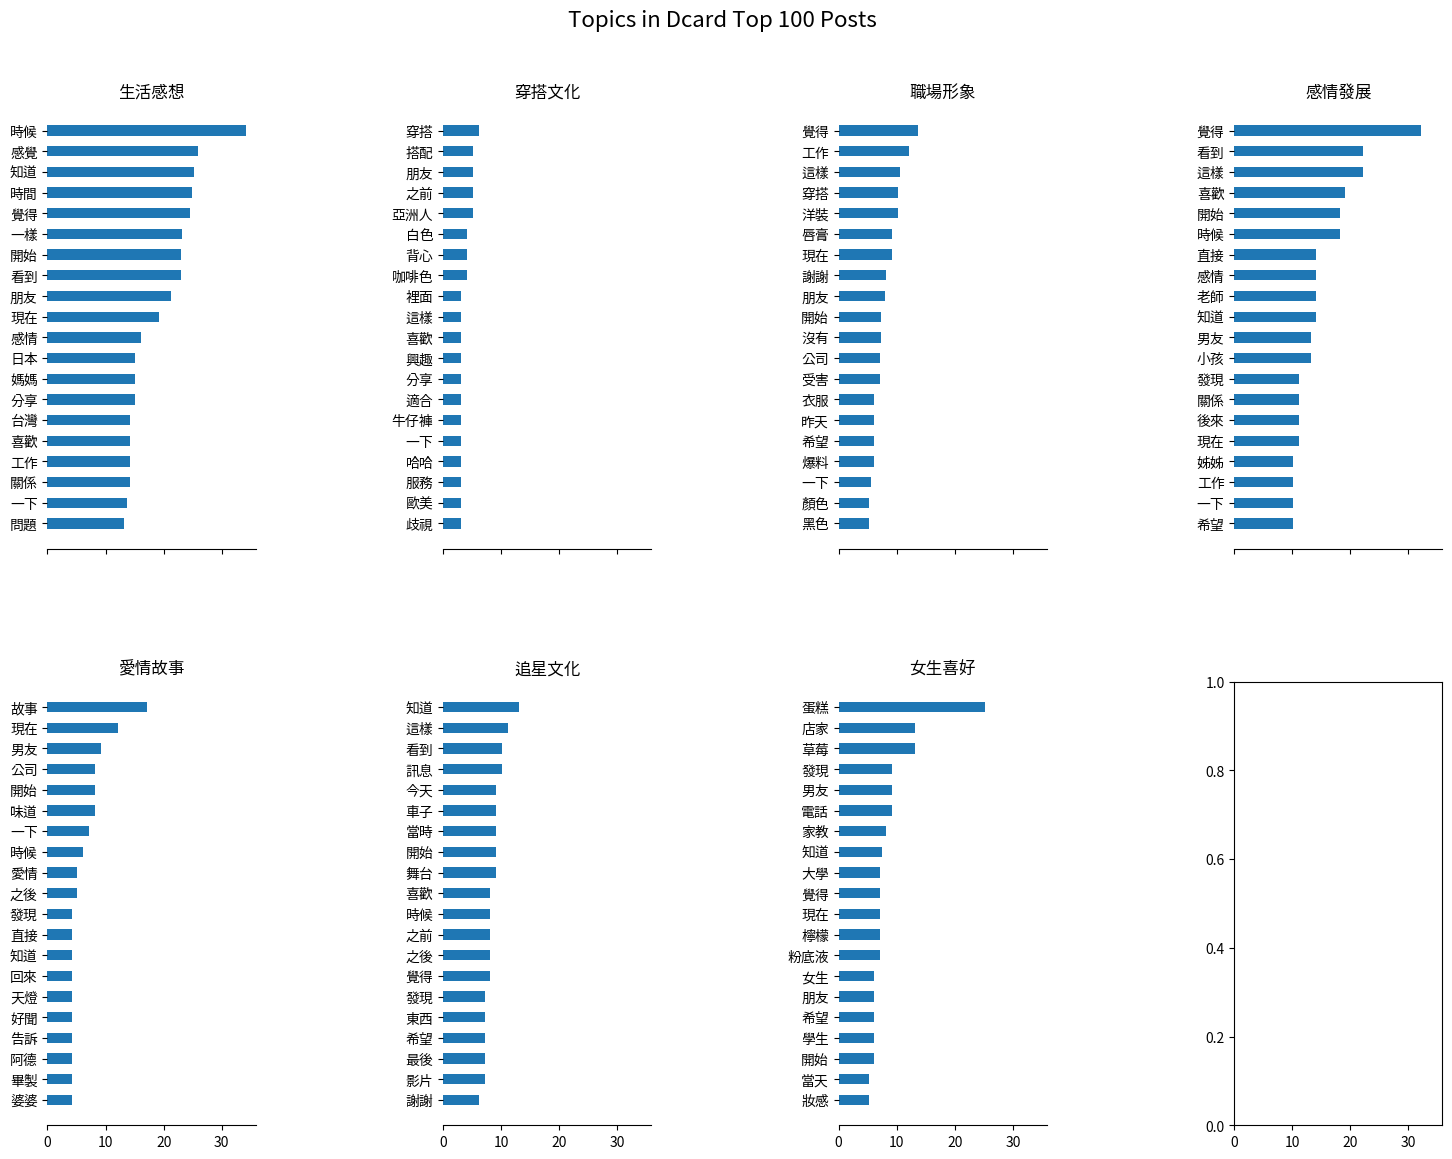

In [48]:
# Define the number of words to show for each topic
n_top_words = 20

# Call the function
plot_top_words(lda, vocab, n_top_words, "Topics in Dcard Top 100 Posts", fig_grid=[2, 4], topic_names=topics)

##**Hyper-parameter tuning**

In [42]:
%%time

## Prepare hyperparameters dict
search_params = {'n_components': range(3,10), 'learning_decay': [.5, .7]} # from .5 to 1

## Initialize LDA
model = LatentDirichletAllocation(learning_method='batch', ## `online` for large datasets (one at a time)
                                  max_iter=100,
                                  random_state=0)

## Gridsearch
gridsearch = GridSearchCV(model,
                          param_grid=search_params,
                          n_jobs=-1,
                          verbose=1) # observe the results
gridsearch.fit(doc_term_matrix)

## Save the best model
best_lda = gridsearch.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
CPU times: user 2.14 s, sys: 239 ms, total: 2.38 s
Wall time: 1min 32s


In [43]:
# What did we find?
print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)
print('Best Model Perplexity: ', best_lda.perplexity(doc_term_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -23208.7327033697
Best Model Perplexity:  3056.3729417569175
